In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from descartes.patch import PolygonPatch
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, box

pd.set_option('display.max_columns', None)

In [2]:
parcels = gpd.read_file('data/parcels/geo_export_c30990f3-ca5c-43ef-ab97-46ff1d4fc38b.shp')

In [3]:
len(parcels)

384675

In [4]:
index = parcels.geometry.sindex

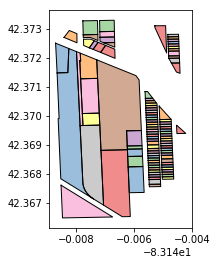

In [5]:
def get_nearest(p, k=5):
    if hasattr(p, 'total_bounds'):
        bounds = p.total_bounds
    elif hasattr(p, 'bounds'):
        bounds = p.bounds
    else:
        bounds = p
    hits = list(index.nearest(bounds, k))
    return parcels.geometry.iloc[hits]

p = parcels.geometry.ix[0]
get_nearest(p, 100).plot()

In [6]:
len(parcels.parcelno), len(parcels.parcelno[~parcels.parcelno.isnull()]), len(parcels.parcelno.unique())

(384675, 384601, 384403)

In [7]:
len(parcels.objectid), len(parcels.objectid[~parcels.objectid.isnull()]), len(parcels.objectid.unique())

(384675, 384675, 384675)

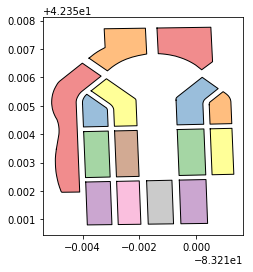

In [8]:
group = parcels[parcels.parcelno == '22002318.001']
group.geometry.plot()

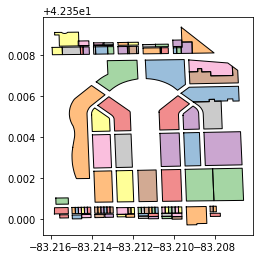

In [9]:
get_nearest(group.geometry, 100).plot()

In [10]:
demolition = pd.read_csv('data/detroit-demolition-permits.tsv', sep='\t')
demolition = demolition.join(demolition.site_location.str.extract(r'\((?P<Lat>.+)?,\s*(?P<Lon>.+)?\)', expand=True).astype(float))
geometry = demolition.apply(lambda row: Point(row.Lon, row.Lat), axis=1)
demolition = gpd.GeoDataFrame(demolition, geometry=geometry, crs={'init': 'epsg:4326'})

In [11]:
demolition[~demolition.PARCEL_NO.str.contains(r'^\d+ +\d+(?:\.(?:\d+L?)?|-\d+)$')]

,PERMIT_NO,PERMIT_APPLIED,PERMIT_ISSUED,PERMIT_EXPIRES,SITE_ADDRESS,BETWEEN1,PARCEL_NO,LOT_NUMBER,SUBDIVISION,CASE_TYPE,CASE_DESCRIPTION,LEGAL_USE,ESTIMATED_COST,PARCEL_SIZE,PARCEL_CLUSTER_SECTOR,STORIES,PARCEL_FLOOR_AREA,PARCEL_GROUND_AREA,PRC_AKA_ADDRESS,BLD_PERMIT_TYPE,PERMIT_DESCRIPTION,BLD_PERMIT_DESC,BLD_TYPE_USE,RESIDENTIAL,DESCRIPTION,BLD_TYPE_CONST_COD,BLD_ZONING_DIST,BLD_USE_GROUP,BLD_BASEMENT,FEE_TYPE,CSM_CASENO,CSF_CREATED_BY,SEQ_NO,PCF_AMT_PD,PCF_AMT_DUE,PCF_UPDATED,OWNER_LAST_NAME,OWNER_FIRST_NAME,OWNER_ADDRESS1,OWNER_ADDRESS2,OWNER_CITY,OWNER_STATE,OWNER_ZIP,CONTRACTOR_LAST_NAME,CONTRACTOR_FIRST_NAME,CONTRACTOR_ADDRESS1,CONTRACTOR_ADDRESS2,CONTRACTOR_CITY,CONTRACTOR_STATE,CONTRACTOR_ZIP,CONDITION_FOR_APPROVAL,site_location,owner_location,contractor_location,geom,Lat,Lon,geometry
6575,BLD2011-01231,2/16/11,2/16/11,8/16/11,17200 SOUTH HAMPTON,NaN,0,NaN,NaN,BLD,Building Permit,SCHOOL,NaN,NaN,NaN,15.0,NaN,NaN,NaN,DISM,Dismantle,WRECK & REMOVE DEBRIS.,41,NON-RESIDENTIAL,School,1B,B1,E,Y,WPMT,BLD2011-01231,M-JD,1,"$5,036.20","$5,036.20",2/16/11,DETROIT PUBLIC SCHOOLS,NaN,3031 W GRAND BLVD,NaN,DETROIT,MI,48202,ADAMO DEMOLITION COMPANY 2011,NaN,300 E SEVEN MILE,NaN,DETROIT,MI,48203.0,NaN,"17200 SOUTH HAMPTON\nDETROIT, MI\n(42.33168113...","3031 W GRAND BLVD\nDETROIT, MI 48202\n(42.3693...","300 E SEVEN\nDETROIT, MI 48203\n(42.3343817120...",NaN,42.331681,-83.047996,POINT (-83.04799603699996 42.33168113800008)
6576,BLD2011-01231,2/16/11,2/16/11,8/16/11,17200 SOUTH HAMPTON,NaN,0,NaN,NaN,BLD,Building Permit,SCHOOL,NaN,NaN,NaN,15.0,NaN,NaN,NaN,DISM,Dismantle,WRECK & REMOVE DEBRIS.,41,NON-RESIDENTIAL,School,1B,B1,E,Y,WPMT,BLD2011-01231,M-JD,1,"$5,036.20","$5,036.20",2/16/11,DETROIT PUBLIC SCHOOLS,NaN,3031 W GRAND BLVD,NaN,DETROIT,MI,48202,ADAMO DEMOLITION COMPANY 2011,NaN,300 E SEVEN MILE,NaN,DETROIT,MI,48203.0,NaN,"17200 SOUTH HAMPTON\nDETROIT, MI\n(42.33168113...","3031 W GRAND BLVD\nDETROIT, MI 48202\n(42.3693...","300 E SEVEN\nDETROIT, MI 48203\n(42.3343817120...",NaN,42.331681,-83.047996,POINT (-83.04799603699996 42.33168113800008)
6969,BLD2010-01114,7/13/10,7/13/10,1/13/11,2920 E PALMER,NaN,0,NaN,NaN,BLD,Building Permit,SCHOOL,NaN,NaN,NaN,1.0,NaN,NaN,NaN,DISM,Dismantle,WRECK AND REMOVE DEBRIS,41,NON-RESIDENTIAL,School,1B,NaN,E,NaN,WPM2,BLD2010-01114,GRE,1,"$2,288.55","$2,288.55",7/13/10,DETROIT PUBLIC SCHOOL,NaN,2920 E PALMER,NaN,DETROIT,MI,48211,FARROW GROUP INC 2010,NaN,601 BEAUFAIT AVE,NaN,DETROIT,MI,48207.0,NaN,"2920 E PALMER\nDETROIT, MI\n(42.37208105400003...","2920 E PALMER\nDETROIT, MI 48211\n(42.37208105...","601 BEAUFAIT AVE\nDETROIT, MI 48207\n(42.34586...",NaN,42.372081,-83.040939,POINT (-83.04093859199997 42.37208105400003)
7116,BLD2010-00154,5/25/10,5/25/10,11/25/10,8210 CAMERON,NaN,0,NaN,NaN,BLD,Building Permit,SCHOOL,NaN,NaN,NaN,2.0,NaN,NaN,NaN,DISM,Dismantle,WRECK AND REMOVE DEBRIS,41,NON-RESIDENTIAL,School,1B,NaN,E,N,WPMT,BLD2010-00154,GRE,1,"$1,425.40","$1,425.40",5/25/10,BEAL,STEWART,221 FELCH ST,NaN,ANN ARBOR,MI,48103,BEAL INCORPORATED,NaN,277 GRATIOT #510,NaN,DETROIT,MI,48226.0,NaN,"8210 CAMERON\nDETROIT, MI\n(42.37923932800004,...","221 FELCH ST\nANN ARBOR, MI 48103\n(42.2863418...","277 GRATIOT\nDETROIT, MI 48226\n(42.3351206730...",NaN,42.379239,-83.065327,POINT (-83.06532742299999 42.37923932800004)


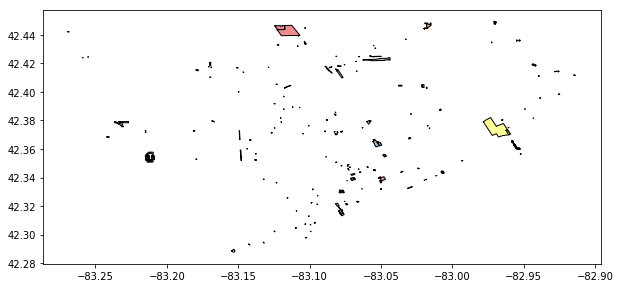

In [12]:
parcel_counts = parcels.parcelno.value_counts()
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
parcels[parcels.parcelno.isin(parcel_counts[parcel_counts > 1].index)].plot(column='parcelno', ax=ax)

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-82.96683165999997,42.430741236000074,-82.951286,42.44725228200008&bboxSR=4326&imageSR=4326&size=800,849&dpi=96&format=png32&f=image


/home/ubuntu/conda/envs/ds/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/ubuntu/conda/envs/ds/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/ubuntu/conda/envs/ds/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/ubuntu/conda/envs/ds/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


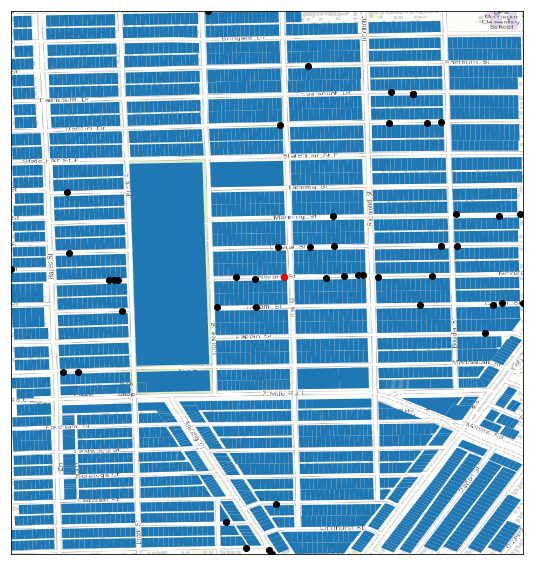

In [13]:
demolition_with_coordinates = demolition[~demolition.Lat.isnull() & ~demolition.Lon.isnull()]

center = demolition_with_coordinates.sample(1).iloc[0].geometry
hits = list(demolition_with_coordinates.sindex.nearest(center.bounds, 50))
demolition_sample = demolition_with_coordinates.iloc[hits]
parcels_sample = parcels[parcels.within(box(*demolition_sample.total_bounds))]

fig, ax = plt.subplots(figsize=(10, 10))

lat_min, lat_max = demolition_sample.Lat.min(), demolition_sample.Lat.max()
lon_min, lon_max = demolition_sample.Lon.min(), demolition_sample.Lon.max()

m = Basemap(
    epsg=4326,
    llcrnrlat=lat_min,
    urcrnrlat=lat_max,
    llcrnrlon=lon_min,
    urcrnrlon=lon_max,
    ax=ax,
)

m.arcgisimage(service='World_Topo_Map', xpixels=800, verbose=True)

ax.add_collection(PatchCollection(parcels_sample.geometry.map(PolygonPatch)))

m.scatter(
    demolition_sample.geometry.map(lambda p: p.x),
    demolition_sample.geometry.map(lambda p: p.y),
    color='k',
)

ax.add_collection(PatchCollection(
    parcels_sample[parcels_sample.parcelno == '01006556.'].geometry.map(PolygonPatch), color='g'))
m.scatter(
    demolition_sample.geometry.map(lambda p: p.x)[:1],
    demolition_sample.geometry.map(lambda p: p.y)[:1],
    color='r',
)

In [14]:
len(demolition), len(parcels)

(7133, 384675)

17 8966.


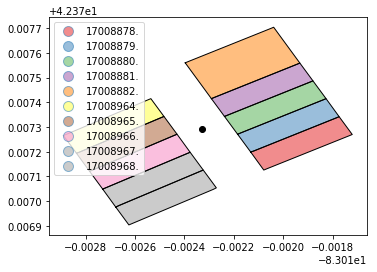

,Distance,parcelno
160737,0.000095,17008966.
160673,0.000103,17008881.
160672,0.000104,17008880.
160736,0.000105,17008965.
160738,0.000105,17008967.
160674,0.000130,17008882.
160671,0.000144,17008879.
160735,0.000164,17008964.
160739,0.000165,17008968.
160670,0.000216,17008878.


In [15]:
def demolition_row_to_parcel(demolition_row):
    print(demolition_row.PARCEL_NO)
    p = demolition_row.geometry
    neighbors = parcels.iloc[list(index.nearest(p.bounds, 10))]
    neighbors.plot(column='parcelno', legend=True)
    plt.scatter([p.x], [p.y], c='k')
    plt.show()
    distances = neighbors.distance(p).sort_values()
    return distances.to_frame('Distance').join(neighbors.loc[distances.index].parcelno)

demolition_row_to_parcel(demolition_with_coordinates.sample().iloc[0])

In [16]:
parcels = parcels[~parcels.parcelno.isnull()]
parcels = parcels.join(parcels.parcelno.str.extract(r'^(?P<Main>\d+)[-\.](?P<Tail>.+?)?\.?$', expand=True).fillna(''))
parcels = parcels.join(parcels.apply(lambda row: '{Main}.{Tail}'.format(**row), axis=1).to_frame('ParcelNo'))
parcels = parcels.drop('parcelno', axis=1)

In [17]:
demolition = demolition.join(demolition.PARCEL_NO.str.extract(r'^(?P<Head>\d+) +(?P<Body>\d+)[-\.](?P<Tail>.+?)?$', expand=True).fillna(''))
demolition = demolition.join(demolition.apply(lambda row: '{Head:>02}{Body:>06}'.format(**row), axis=1).to_frame('Main'))
demolition = demolition.join(demolition.apply(lambda row: '{Head:>02}{Body:>06}.{Tail}'.format(**row), axis=1).to_frame('ParcelNo'))
demolition = demolition.drop('PARCEL_NO', axis=1)

In [18]:
same_main = pd.merge(demolition[['ParcelNo', 'SITE_ADDRESS', 'Main', 'Tail']],
             parcels[['Main', 'Tail', 'ParcelNo', 'propaddr']],
             on='Main', how='inner').fillna('')
same_tail = same_main[same_main.Tail_x == same_main.Tail_y]
same_main_different_tail = same_main[~same_main.Main.isin(same_tail.Main)].sort_values('Main')
same_main_different_tail[['Main', 'Tail_x', 'Tail_y', 'ParcelNo_x', 'ParcelNo_y', 'SITE_ADDRESS', 'propaddr']]

,Main,Tail_x,Tail_y,ParcelNo_x,ParcelNo_y,SITE_ADDRESS,propaddr
4377,01004087,97,96,01004087.97,01004087.96,500 WOODWARD,500 WOODWARD AVENUE
4376,01004087,97,96,01004087.97,01004087.96,500 WOODWARD 19TH FLOOR,500 WOODWARD AVENUE
8625,01007676,,7,01007676.,01007676.7,974 FERNHILL,974 FERNHILL
8860,04002764,,5,04002764.,04002764.5,630 W BOSTON BLVD,610 W BOSTON BLVD
1218,06006164,,8,06006164.,06006164.8,4801 ELMHURST,1584 ELMHURST
8817,08003913,,0,08003913.,08003913.0,2335 HIGHLAND,2335 HIGHLAND
8816,08003913,,0,08003913.,08003913.0,2335 HIGHLAND,2335 HIGHLAND
1090,10005318,,9,10005318.,10005318.9,1481 14TH,1435 14TH ST
8531,12004504,,16,12004504.,12004504.16,3026 W DAVISON,2900 W DAVISON
7716,12008654,002L,,12008654.002L,12008654.,3606 TWENTYFIFTH,3602 24TH ST


In [19]:
from IPython.display import display

def inspect(main):
    p = parcels[parcels.Main == main]
    g = demolition[demolition.Main == main]
    if g.Lat.isnull().any():
        return
    display(p[['propaddr', 'ParcelNo']])
    display(g[['SITE_ADDRESS', 'ParcelNo']])
    fig, ax = plt.subplots()
    get_nearest(g, 10).plot(ax=ax, color='white')
    p.plot(ax=ax)
    g.plot(color='r', ax=ax)
    plt.show()

mains = list(same_main_different_tail.Main.unique())
# The code below crashes the kernel.
#for main in mains:
#    inspect(main)

In [20]:
demolition.BLD_PERMIT_TYPE.unique()

array(['Dismantle', 'DISM'], dtype=object)

In [21]:
parcels.sample()

,aka,av,cibbldgno,cibflarea,cibocc,cibyrbuilt,date_saled,depth,district,ecf,frontage,geometry,homestead,isimproved,landmap,landvalue,legal,nez,objectid,prevpclass,prevtstatu,propaddr,propclass,propdir,propno,propstatus,propstr,propzip,related,resbldgno,resflarea,resocc,resstyle,resyrbuilt,rp,saleprice,sev,shape_star,shape_stle,specact,subdivisio,taxaddr,taxcity,taxpayer_1,taxpayer_2,taxstate,taxstatus,taxzip,time_saled,totalacrea,totalsqft,tv,usecode,ward,xstrname_1,xstrname_2,Main,Tail,ParcelNo
119561,None,0.0,0.0,0.0,0.0,0.0,1899-11-30,126.0,9.0,93421,30.0,POLYGON ((-83.14239991804492 42.40662285874895...,0.0,0.0,166,507.0,"S GLOBE 21 ASTON & GITTINS SUB L31 P80 PLATS, ...",None,38802.0,461,STATE LAND BANK,6399 GLOBE,461,None,6399.0,Active,GLOBE,48238,None,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,3780.427246,312.15765,None,None,PO BOX 30004,LANSING,MI LAND BANK FAST TRACK AUTH,MI DEPT OF LABOR & ECONOMIC GROWTH,MI,STATE LAND BANK,48909,00:00:00.000,0.087,3790.0,0.0,41110,16,LIVERNOIS,MONICA,16007309,,16007309.


In [22]:
dataset = parcels[['ParcelNo', 'propaddr', 'geometry']].rename(columns={'propaddr': 'StreetAddress'})
dataset['IsBlighted'] = dataset.ParcelNo.isin(demolition.ParcelNo)
dataset = dataset.reindex(np.random.permutation(dataset.index))
dataset = dataset[dataset.IsBlighted | ((~dataset.IsBlighted).cumsum() <= dataset.IsBlighted.sum())]
dataset = dataset.reindex(np.random.permutation(dataset.index))

In [23]:
len(dataset), dataset.IsBlighted.mean()

(12444, 0.5)

In [24]:
!mkdir -p output

In [25]:
dataset.to_csv('output/dataset.csv')